# Artificial Neural Network (Deep Learning)

## Skip to a Section

- [Simple Trial Model](#Simple-Trial-Model)
- [Adding in Cross Validation](#Adding-in-Cross-Validation)
- [Adding in Loops](#Adding-in-Loops)
- [Wild Wild West Models](#Wild-Wild-West-Models)
 - [Model 1 – Changing the Number of Folds](#Model-1-–-Changing–the-Number-of-Folds)
 - [Model 2 – Changing the Number of Loops](#Model-2-–-Changing–the-Number-of-Loops)
 - [Model 3 – Changing the Number of Layers](#Model-3-–-Changing–the-Number-of-Layers)
 - [Model 4 – Changing the Number of Neurons](#Model-4-–-Changing–the-Number-of-Neurons)
 - [Model 5 – Changing the Activation Function](#Model-5-–-Changing–the-Activation-Function)
 - [Model 6 – Changing the Optimizer](#Model-6-–-Changing–the-Optimizer)
 - [Model 7 – Changing the Loss Function](#Model-7-–-Changing–the-Loss-Function)
 - [Model 8 – Changing the Number of Epochs](#Model-8-–-Changing–the-Number-of-Epochs)
 - [Model 9 – Changing the Batch Size](#Model-9-–-Changing–the-Batch-Size)
- [Final Model](#Final-Model)

We begin by importing the necessary libraries.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.lines as mlines
import statsmodels.api as sm
import tensorflow as tf
import RegscorePy
import pydot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from stargazer.stargazer import Stargazer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from RegscorePy import aic
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from keras.utils.vis_utils import plot_model
from ann_visualizer.visualize import ann_viz

In [115]:
tf.__version__

'2.1.0'

We read in the dataset and save it under data.

In [116]:
data = pd.read_csv('data_preprocessed.csv')

## Simple Trial Model

We start out by creating a simple trial model.

We set our regressors/explanatory variables and our dependent variable.

In [4]:
X = data.drop(['lnpercapitaconsumption'],axis=1)
y = data['lnpercapitaconsumption']

We check for the shape of our regressor matrix.

In [5]:
X.shape

(22674, 64)

We check for the shape of our dependent variable.

In [6]:
y.shape

(22674,)

In order for our ANN to work, we must first reshape our dependent variable.

In [7]:
y = y.values.reshape(-1,1)

We now set up the architecture of our NN. We create one input layer, three hidden layers (with 64 neurons each) and one output layer. We use linear activation functions.

In [8]:
model = Sequential()
model.add(Dense(64,input_dim=64,activation='linear'))
model.add(Dense(64,activation='linear'))
model.add(Dense(64,activation='linear'))
model.add(Dense(1,activation='linear'))

We can summarize our model.

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________


We can visualize our model.

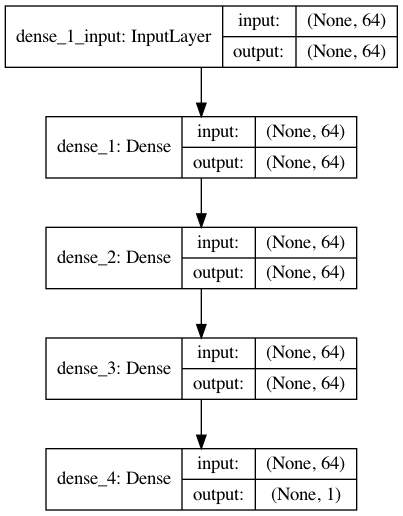

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True)

We can compile our model. We use the adam optimizer and the mean squared error as our loss function.

In [11]:
model.compile(optimizer='adam',loss='mean_squared_error')

We can fit our model. We run 30 epochs, train on a batch size of 20 and create a validation set with a split of 0.2.

In [12]:
epochs_hist = model.fit(X,y,epochs=30,batch_size=32,verbose=1,validation_split=0.2)

Train on 18139 samples, validate on 4535 samples
Epoch 1/30
18139/18139 [==============================] - 1s 41us/step - loss: 0.7480 - val_loss: 0.2369
Epoch 2/30
18139/18139 [==============================] - 1s 33us/step - loss: 0.2410 - val_loss: 0.2377
Epoch 3/30
18139/18139 [==============================] - 1s 34us/step - loss: 0.2336 - val_loss: 0.2194
Epoch 4/30
18139/18139 [==============================] - 1s 32us/step - loss: 0.2262 - val_loss: 0.2184
Epoch 5/30
18139/18139 [==============================] - 1s 32us/step - loss: 0.2228 - val_loss: 0.2107
Epoch 6/30
18139/18139 [==============================] - 1s 33us/step - loss: 0.2223 - val_loss: 0.2408
Epoch 7/30
18139/18139 [==============================] - 1s 34us/step - loss: 0.2186 - val_loss: 0.2177
Epoch 8/30
18139/18139 [==============================] - 1s 32us/step - loss: 0.2145 - val_loss: 0.2410
Epoch 9/30
18139/18139 [==============================] - 1s 34us/step - loss: 0.2150 - val_loss: 0.2132
Epoch 

We can plot the training process.

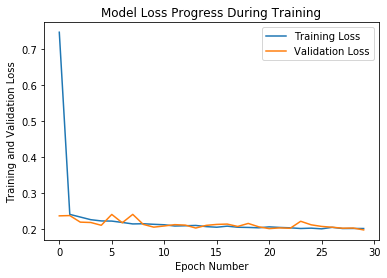

In [13]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.ylabel('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss','Validation Loss'])

We can make our predictions.

In [14]:
y_predict = model.predict(X)

We can calculate the mean squared error.

In [15]:
sklearn.metrics.mean_squared_error(y, y_predict)

0.1947530403751737

We can plot our predictions.

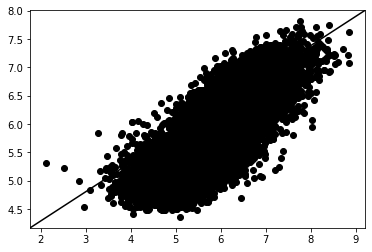

In [16]:
x, y = y,y_predict
fig, ax = plt.subplots()
ax.scatter(x, y, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

## Adding in Cross Validation

We now add in cross validation into our simple trial model. 

In [5]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Creating k-folds
kf = KFold(3, shuffle=True, random_state=123)

actual_values = []
predicted_values = []

# Running k-fold cross-validation 
fold = 0
for train, test in kf.split(X):
    fold+=1
    print(f"Fold #{fold}")
        
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(64,input_dim=64,activation='linear'))
    model.add(Dense(64,activation='linear'))
    model.add(Dense(64,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer='adam',loss='mean_squared_error')
    
    model.fit(X_train,y_train,epochs=30,batch_size=32,verbose=0)
    
    predictions = model.predict(X_test)
    
    actual_values.append(y_test)
    predicted_values.append(predictions)    

    score = metrics.mean_squared_error(predictions,y_test)
    print(f"Fold MSE: {score}")

score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
print(f"CV MSE: {score}") 

all_predictions = model.predict(X)
score = metrics.mean_squared_error(all_predictions,y)
print(f"Training MSE: {score}")

Fold #1
Fold MSE: 0.2010856049176254
Fold #2
Fold MSE: 0.2180732108779894
Fold #3
Fold MSE: 0.20332749345015297
CV MSE: 0.20749543641525592
Training MSE: 0.2014770348512965


## Adding in Loops

We now add in loops.

In [20]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Creating k-folds
kf = KFold(3, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,3):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        
        model = Sequential()
        model.add(Dense(64,input_dim=64,activation='linear'))
        model.add(Dense(64,activation='linear'))
        model.add(Dense(64,activation='linear'))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer='adam',loss='mean_squared_error')
    
        model.fit(X_train,y_train,epochs=30,batch_size=32,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.19042676994150798
Fold #2
Fold MSE: 0.2025297302203081
Fold #3
Fold MSE: 0.19528147033375082
CV MSE: 0.19607932349852225
Training MSE: 0.19412487435460088
Fold #1
Fold MSE: 0.1995900894334466
Fold #2
Fold MSE: 0.2146631231937462
Fold #3
Fold MSE: 0.20736458903595187
CV MSE: 0.20164262869311855
Training MSE: 0.2056524560001342
Fold #1
Fold MSE: 0.19477280216655773
Fold #2
Fold MSE: 0.19881929051897038
Fold #3
Fold MSE: 0.20472208011059043
CV MSE: 0.20090777166164778
Training MSE: 0.2030599058296538


In [21]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.1997798323466427


## Wild Wild West Models

Now that we have added in both cross validation as well as loops into our simple trial model, we can work on the architecture and the parameters of the model. Since there is no formal way of going about this, some trial and error is needed.

### Model 1 – Changing the Number of Folds

We change the number of folds to 10.

#### k = 5

In [6]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 5
number_of_loops = 3
activation_function = 'linear'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        
        model = Sequential()
        model.add(Dense(64,input_dim=64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.2064130354165986
Fold #2
Fold MSE: 0.19651134000296275
Fold #3
Fold MSE: 0.2060928832003246
Fold #4
Fold MSE: 0.201869965345964
Fold #5
Fold MSE: 0.2040529148070418
CV MSE: 0.20298798078946184
Training MSE: 0.2000325956818398
Fold #1
Fold MSE: 0.21068862084445725
Fold #2
Fold MSE: 0.1960896016990919
Fold #3
Fold MSE: 0.2000770845982959
Fold #4
Fold MSE: 0.2138826403533859
Fold #5
Fold MSE: 0.22315011914050167
CV MSE: 0.20588248012027355
Training MSE: 0.21625056476744148
Fold #1
Fold MSE: 0.1960405631847143
Fold #2
Fold MSE: 0.20536188501952293
Fold #3
Fold MSE: 0.2014439519637172
Fold #4
Fold MSE: 0.19478057427236825
Fold #5
Fold MSE: 0.1988663103461445
CV MSE: 0.2036878787552622
Training MSE: 0.19586295429875275


In [7]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.196833920564887


#### k = 10

In [7]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 3
activation_function = 'linear'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        
        model = Sequential()
        model.add(Dense(64,input_dim=64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.23423241624306848
Fold #2
Fold MSE: 0.1921087502970323
Fold #3
Fold MSE: 0.1902336027004213
Fold #4
Fold MSE: 0.19885020676429477
Fold #5
Fold MSE: 0.19300560344961176
Fold #6
Fold MSE: 0.21122562458566754
Fold #7
Fold MSE: 0.19619695151298647
Fold #8
Fold MSE: 0.1958433522222313
Fold #9
Fold MSE: 0.20404427741788397
Fold #10
Fold MSE: 0.19873772413384508
CV MSE: 0.20144827580578686
Training MSE: 0.1977974441065371
Fold #1
Fold MSE: 0.20316470866510108
Fold #2
Fold MSE: 0.19233867890213727
Fold #3
Fold MSE: 0.18879536123017157
Fold #4
Fold MSE: 0.19208248224152083
Fold #5
Fold MSE: 0.20956960037905842
Fold #6
Fold MSE: 0.21262896897996375
Fold #7
Fold MSE: 0.19849443562139668
Fold #8
Fold MSE: 0.19636610650397357
Fold #9
Fold MSE: 0.20693343798445352
Fold #10
Fold MSE: 0.19711590134000842
CV MSE: 0.2005981233042335
Training MSE: 0.19758850889875199
Fold #1
Fold MSE: 0.20453697235934923
Fold #2
Fold MSE: 0.19339234299671887
Fold #3
Fold MSE: 0.21561054675205185
Fold 

In [8]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.1926866544210749


### Model 2 – Changing the Number of Loops

In [9]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'linear'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        
        model = Sequential()    
        model.add(Dense(64,input_dim=64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.19955671841069114
Fold #2
Fold MSE: 0.19496794107211346
Fold #3
Fold MSE: 0.1915561418720811
Fold #4
Fold MSE: 0.1930250860695741
Fold #5
Fold MSE: 0.19234961373351628
Fold #6
Fold MSE: 0.21338896281649772
Fold #7
Fold MSE: 0.19764839465820425
Fold #8
Fold MSE: 0.19644041768871642
Fold #9
Fold MSE: 0.20301085811416353
Fold #10
Fold MSE: 0.1953062007589671
CV MSE: 0.19772451335333038
Training MSE: 0.19498011715226612
Fold #1
Fold MSE: 0.23055506979012702
Fold #2
Fold MSE: 0.19726736635922942
Fold #3
Fold MSE: 0.19496933117577048
Fold #4
Fold MSE: 0.1915888932983605
Fold #5
Fold MSE: 0.18962499947267422
Fold #6
Fold MSE: 0.2118642675124474
Fold #7
Fold MSE: 0.19751446444819765
Fold #8
Fold MSE: 0.19167185394819497
Fold #9
Fold MSE: 0.21594327062249893
Fold #10
Fold MSE: 0.19571152148447818
CV MSE: 0.1996979782974749
Training MSE: 0.1954843579813791
Fold #1
Fold MSE: 0.20167272950397688
Fold #2
Fold MSE: 0.19174002747482718
Fold #3
Fold MSE: 0.19147092377878244
Fold #4

In [10]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.19215103984618076


### Model 3 – Changing the Number of Layers

In [12]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'linear'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]

        model = Sequential()        
        model.add(Dense(64,input_dim=64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(64,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.1980491028763154
Fold #2
Fold MSE: 0.19857621666359757
Fold #3
Fold MSE: 0.18860549631745893
Fold #4
Fold MSE: 0.21157756576193174
Fold #5
Fold MSE: 0.19967705958356577
Fold #6
Fold MSE: 0.20553929486621905
Fold #7
Fold MSE: 0.19283860947258122
Fold #8
Fold MSE: 0.19223795368091476
Fold #9
Fold MSE: 0.20028168494105386
Fold #10
Fold MSE: 0.19507404249212565
CV MSE: 0.19824587138617958
Training MSE: 0.19556918058058056
Fold #1
Fold MSE: 0.19994994020730575
Fold #2
Fold MSE: 0.19568698158229264
Fold #3
Fold MSE: 0.19157048832230236
Fold #4
Fold MSE: 0.1985138589442548
Fold #5
Fold MSE: 0.2001472465264937
Fold #6
Fold MSE: 0.20678590722396012
Fold #7
Fold MSE: 0.20724034299571206
Fold #8
Fold MSE: 0.19104458875409103
Fold #9
Fold MSE: 0.20098086438479276
Fold #10
Fold MSE: 0.19633826893070083
CV MSE: 0.198535648784619
Training MSE: 0.19776988630107792
Fold #1
Fold MSE: 0.20899344274926365
Fold #2
Fold MSE: 0.195509538913705
Fold #3
Fold MSE: 0.18863134468659978
Fold #4

In [13]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.19182775139807356


### Model 4 – Changing the Number of Neurons

In [14]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'linear'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
 
        model = Sequential()
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.19841526711229301
Fold #2
Fold MSE: 0.19235773460427605
Fold #3
Fold MSE: 0.18825699027884255
Fold #4
Fold MSE: 0.20277611992231326
Fold #5
Fold MSE: 0.19229006777317625
Fold #6
Fold MSE: 0.20913143477211357
Fold #7
Fold MSE: 0.1960039025962177
Fold #8
Fold MSE: 0.1922971993851181
Fold #9
Fold MSE: 0.20253109007122724
Fold #10
Fold MSE: 0.19433080412840126
CV MSE: 0.19683881628481162
Training MSE: 0.1934269560407812
Fold #1
Fold MSE: 0.2021072937814307
Fold #2
Fold MSE: 0.19355510183418267
Fold #3
Fold MSE: 0.19451065043293736
Fold #4
Fold MSE: 0.20099357063255535
Fold #5
Fold MSE: 0.19274451444422572
Fold #6
Fold MSE: 0.2196976314865963
Fold #7
Fold MSE: 0.19379544976216018
Fold #8
Fold MSE: 0.19467027926494723
Fold #9
Fold MSE: 0.20320413830244013
Fold #10
Fold MSE: 0.20349046412418637
CV MSE: 0.19835767891208778
Training MSE: 0.20179238778617126
Fold #1
Fold MSE: 0.19981565351878422
Fold #2
Fold MSE: 0.1933721542364619
Fold #3
Fold MSE: 0.18782686547724411
Fold #

In [15]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.19315023295134642


### Model 5 – Changing the Activation Function

#### relu

In [17]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'relu'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.1983453372998048
Fold #2
Fold MSE: 0.18734464455856756
Fold #3
Fold MSE: 0.19069394684822608
Fold #4
Fold MSE: 0.18838068246375572
Fold #5
Fold MSE: 0.18540012989313373
Fold #6
Fold MSE: 0.20416896328977907
Fold #7
Fold MSE: 0.18776088868506105
Fold #8
Fold MSE: 0.1984026479184563
Fold #9
Fold MSE: 0.20232165911557343
Fold #10
Fold MSE: 0.1915409830235195
CV MSE: 0.19343559229026747
Training MSE: 0.18619795087238306
Fold #1
Fold MSE: 0.19615209150131754
Fold #2
Fold MSE: 0.20460868505738794
Fold #3
Fold MSE: 0.18664745058922738
Fold #4
Fold MSE: 0.19636297512770642
Fold #5
Fold MSE: 0.18624400389396906
Fold #6
Fold MSE: 0.20043729894380685
Fold #7
Fold MSE: 0.18397530962384467
Fold #8
Fold MSE: 0.1898158541685901
Fold #9
Fold MSE: 0.20256261358653405
Fold #10
Fold MSE: 0.20267839764133871
CV MSE: 0.1941921178586696
Training MSE: 0.1990264398180989
Fold #1
Fold MSE: 0.20194769006761057
Fold #2
Fold MSE: 0.19348875984009092
Fold #3
Fold MSE: 0.18497889538462073
Fold #

In [18]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.18271925167417766


#### sigmoid

In [19]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.18930775164060937
Fold #2
Fold MSE: 0.18371622353741415
Fold #3
Fold MSE: 0.1789011404861826
Fold #4
Fold MSE: 0.18677364569482452
Fold #5
Fold MSE: 0.18138037629274367
Fold #6
Fold MSE: 0.1974574952016907
Fold #7
Fold MSE: 0.18411227394710936
Fold #8
Fold MSE: 0.18367282351744788
Fold #9
Fold MSE: 0.19362586355013892
Fold #10
Fold MSE: 0.18142502522295142
CV MSE: 0.18603702153307364
Training MSE: 0.18252511679698696
Fold #1
Fold MSE: 0.188513939423288
Fold #2
Fold MSE: 0.184261624287999
Fold #3
Fold MSE: 0.17886009262473845
Fold #4
Fold MSE: 0.18491230753260973
Fold #5
Fold MSE: 0.1813806761334456
Fold #6
Fold MSE: 0.19703884811002625
Fold #7
Fold MSE: 0.18345945851175818
Fold #8
Fold MSE: 0.18270302037368855
Fold #9
Fold MSE: 0.19168754311350183
Fold #10
Fold MSE: 0.18334598424902188
CV MSE: 0.18582655499512823
Training MSE: 0.18327893544374133
Fold #1
Fold MSE: 0.18862365102927198
Fold #2
Fold MSE: 0.18354169004344864
Fold #3
Fold MSE: 0.17835065470567893
Fold #4

In [20]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.18169252929541266


#### softmax

In [21]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'softmax'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.18999779209612253
Fold #2
Fold MSE: 0.18447301610550162
Fold #3
Fold MSE: 0.18122207633794182
Fold #4
Fold MSE: 0.18631412457241858
Fold #5
Fold MSE: 0.1822502230308734
Fold #6
Fold MSE: 0.19950935932752992
Fold #7
Fold MSE: 0.18537376100400219
Fold #8
Fold MSE: 0.18388477231124037
Fold #9
Fold MSE: 0.19328389327159795
Fold #10
Fold MSE: 0.18356754517675483
CV MSE: 0.18698739418984528
Training MSE: 0.18323340721825412
Fold #1
Fold MSE: 0.1883926532447202
Fold #2
Fold MSE: 0.18391878676032491
Fold #3
Fold MSE: 0.17875468397458835
Fold #4
Fold MSE: 0.18643607739231313
Fold #5
Fold MSE: 0.18089231629879812
Fold #6
Fold MSE: 0.19842665271389964
Fold #7
Fold MSE: 0.1853078010629129
Fold #8
Fold MSE: 0.18201130131027649
Fold #9
Fold MSE: 0.19387228399481277
Fold #10
Fold MSE: 0.18446287913949336
CV MSE: 0.18661730376707691
Training MSE: 0.1824452531051084
Fold #1
Fold MSE: 0.18839654778215348
Fold #2
Fold MSE: 0.1841424570980042
Fold #3
Fold MSE: 0.18076017745719541
Fold 

In [22]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.18157170862555


#### tanh

In [23]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'tanh'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.18873802208569207
Fold #2
Fold MSE: 0.1897465801268341
Fold #3
Fold MSE: 0.17854717296448658
Fold #4
Fold MSE: 0.18691167682073614
Fold #5
Fold MSE: 0.1832773996413265
Fold #6
Fold MSE: 0.1943088665943335
Fold #7
Fold MSE: 0.1840510913469607
Fold #8
Fold MSE: 0.18644797309745503
Fold #9
Fold MSE: 0.19512810843515838
Fold #10
Fold MSE: 0.18694336531843808
CV MSE: 0.18740977440160664
Training MSE: 0.18274870621808978
Fold #1
Fold MSE: 0.18892449970291997
Fold #2
Fold MSE: 0.1844269512090597
Fold #3
Fold MSE: 0.1779001410694779
Fold #4
Fold MSE: 0.18755054481428043
Fold #5
Fold MSE: 0.18477369396010193
Fold #6
Fold MSE: 0.1972915625346663
Fold #7
Fold MSE: 0.18506506440953846
Fold #8
Fold MSE: 0.18524096608956786
Fold #9
Fold MSE: 0.19503260409246886
Fold #10
Fold MSE: 0.18448722074556131
CV MSE: 0.18723934068884385
Training MSE: 0.18197860635860183
Fold #1
Fold MSE: 0.1867521091933846
Fold #2
Fold MSE: 0.18711487394624976
Fold #3
Fold MSE: 0.17945503661368237
Fold #4


In [24]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.17859027413229092


### Model 6 – Changing the Optimizer

In [26]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'tanh'
optimizer = 'sgd'
loss_function = 'mean_squared_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.19397873312466862
Fold #2
Fold MSE: 0.1868293822238547
Fold #3
Fold MSE: 0.18072080955638753
Fold #4
Fold MSE: 0.18932892263354495
Fold #5
Fold MSE: 0.18438406827747114
Fold #6
Fold MSE: 0.1983457566757313
Fold #7
Fold MSE: 0.18433393825120392
Fold #8
Fold MSE: 0.18370165038347472
Fold #9
Fold MSE: 0.19464162029059265
Fold #10
Fold MSE: 0.1856905810128462
CV MSE: 0.1881954613731957
Training MSE: 0.18527702586121475
Fold #1
Fold MSE: 0.18959592912414996
Fold #2
Fold MSE: 0.19193187296706576
Fold #3
Fold MSE: 0.17901300703495826
Fold #4
Fold MSE: 0.1907677389728634
Fold #5
Fold MSE: 0.1830532578315546
Fold #6
Fold MSE: 0.19975808256959462
Fold #7
Fold MSE: 0.19261206080163906
Fold #8
Fold MSE: 0.18597557054260563
Fold #9
Fold MSE: 0.2023062050364741
Fold #10
Fold MSE: 0.18489345303065205
CV MSE: 0.18909289873973362
Training MSE: 0.1839926622895354
Fold #1
Fold MSE: 0.190403880772718
Fold #2
Fold MSE: 0.186747859614119
Fold #3
Fold MSE: 0.18545554977404977
Fold #4
Fold

In [27]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.18357552310336162


### Model 7 – Changing the Loss Function

In [ ]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'tanh'
optimizer = 'adam'
loss_function = 'mean_absolute_error'
number_of_epochs = 30
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

In [ ]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

### Model 8 – Changing the Number of Epochs

In [28]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'tanh'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 100
batch_size = 32

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.18798200584137922
Fold #2
Fold MSE: 0.18614074774977232
Fold #3
Fold MSE: 0.18075123682798014
Fold #4
Fold MSE: 0.18803282602279386
Fold #5
Fold MSE: 0.18331242352924293
Fold #6
Fold MSE: 0.19815027135715818
Fold #7
Fold MSE: 0.18802425302945627
Fold #8
Fold MSE: 0.1839236031796157
Fold #9
Fold MSE: 0.1937359250153513
Fold #10
Fold MSE: 0.18671800664837362
CV MSE: 0.1876767858386429
Training MSE: 0.18160778569068894
Fold #1
Fold MSE: 0.18666024717701463
Fold #2
Fold MSE: 0.18850039362255006
Fold #3
Fold MSE: 0.18047745123054768
Fold #4
Fold MSE: 0.1853424903212028
Fold #5
Fold MSE: 0.18421137229353096
Fold #6
Fold MSE: 0.1951591684334713
Fold #7
Fold MSE: 0.18864762007714825
Fold #8
Fold MSE: 0.1851185424809407
Fold #9
Fold MSE: 0.19699015244218335
Fold #10
Fold MSE: 0.18559598879930495
CV MSE: 0.18767335034444577
Training MSE: 0.1792727978812763
Fold #1
Fold MSE: 0.1850718749074478
Fold #2
Fold MSE: 0.18557179407849572
Fold #3
Fold MSE: 0.18181137642548584
Fold #4


In [29]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.17403870272018077


### Model 9 – Changing the Batch Size

In [4]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'tanh'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 100
batch_size = 20

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X)
    score = metrics.mean_squared_error(all_predictions,y)
    print(f"Training MSE: {score}")
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.189294438852302
Fold #2
Fold MSE: 0.1854945262107738
Fold #3
Fold MSE: 0.18464937467545517
Fold #4
Fold MSE: 0.19416579014129054
Fold #5
Fold MSE: 0.18391602543961688
Fold #6
Fold MSE: 0.19873841073637563
Fold #7
Fold MSE: 0.194418292390045
Fold #8
Fold MSE: 0.18299500135023813
Fold #9
Fold MSE: 0.19691058220297758
Fold #10
Fold MSE: 0.18891896140557893
CV MSE: 0.18994986705690348
Training MSE: 0.17889204302076409
Fold #1
Fold MSE: 0.1869314373500391
Fold #2
Fold MSE: 0.20190746607958654
Fold #3
Fold MSE: 0.18027930337123807
Fold #4
Fold MSE: 0.1870575455140215
Fold #5
Fold MSE: 0.18615956674080883
Fold #6
Fold MSE: 0.1979142414391645
Fold #7
Fold MSE: 0.188751210876898
Fold #8
Fold MSE: 0.18366877042572557
Fold #9
Fold MSE: 0.19888317908542671
Fold #10
Fold MSE: 0.18914200066176612
CV MSE: 0.19000957914665084
Training MSE: 0.1804702226340716
Fold #1
Fold MSE: 0.195812307503777
Fold #2
Fold MSE: 0.18855063402325176
Fold #3
Fold MSE: 0.17913011455997319
Fold #4
Fold 

In [5]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

final_predictions = all_predictions_looped['prediction_mean']
score = metrics.mean_squared_error(final_predictions,y)
print(f"Final Training MSE: {score}")

Final Training MSE: 0.17380426385923103


In [6]:
final_predictions.to_csv('training_predictions.csv', index = False, header=True)

## Final Model

In [4]:
data2 = pd.read_csv('peru_matlab_export_full.csv')

In [5]:
data2.head()

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,...,d_lux_4,d_lux_5,training,percapitaconsumption,poor,h_hhsize,id_for_matlab,hhid,lncaphat_OLS,percapitahat_OLS
0,5.351858,0,1,0,0,0,0,0,0,1,...,0,0,0,211.0000,0,1,1,233710511,5.246471,284.4243
1,5.768755,0,0,0,0,1,0,0,0,0,...,0,0,0,320.1389,0,3,2,295508011,6.129468,522.8840
2,5.968277,0,0,0,0,1,0,0,0,0,...,0,0,0,390.8318,0,4,3,257600211,6.665577,878.4961
3,5.654599,0,0,0,0,1,0,0,0,0,...,0,0,0,285.6018,1,9,4,198104311,6.088295,567.4705
4,4.771289,0,1,0,0,0,0,0,0,1,...,0,0,0,118.0713,1,8,5,24805311,5.008170,115.4929


In [6]:
data2 = data2[data2['training']==0]

In [7]:
data2.shape

(23152, 81)

In [8]:
data2 <- data2.drop(['percapitaconsumption','d_fuel_other','d_water_other','d_wall_other','d_roof_other','d_floor_other','d_insurance_0','d_crowd_lessthan1','d_lux_0','training','poor','h_hhsize','id_for_matlab','hhid','lncaphat_OLS','percapitahat_OLS'], axis = 1, inplace = True)

TypeError: bad operand type for unary -: 'NoneType'

In [9]:
data2.dropna(axis=0,inplace=True)

In [10]:
data2.shape

(22704, 65)

In [17]:
# Creating the regressor matrix and the dependent variable vector.
X = data.drop(['lnpercapitaconsumption'],axis=1).values
y = data['lnpercapitaconsumption'].values
X_holdout = data2.drop(['lnpercapitaconsumption'],axis=1).values
y_holdout = data2['lnpercapitaconsumption'].values

# Parameters
k = 10
number_of_loops = 10
activation_function = 'tanh'
optimizer = 'adam'
loss_function = 'mean_squared_error'
number_of_epochs = 100
batch_size = 20

# Creating k-folds
kf = KFold(k, shuffle=True, random_state=123)

actual_values = []
predicted_values = []
all_predictions_looped = []

# Running k-fold cross-validation
for n in range(0,number_of_loops):
    fold = 0
    for train, test in kf.split(X):
        
        fold+=1
        print(f"Fold #{fold}")
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
        model = Sequential()        
        model.add(Dense(6,input_dim=64,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(6,activation=activation_function))
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=optimizer,loss=loss_function)
    
        model.fit(X_train,y_train,epochs=number_of_epochs,batch_size=batch_size,verbose=0)
    
        predictions = model.predict(X_test)
    
        actual_values.append(y_test)
        predicted_values.append(predictions)    
  
        score = metrics.mean_squared_error(predictions,y_test)
        print(f"Fold MSE: {score}")

    score = metrics.mean_squared_error(np.concatenate(predicted_values),np.concatenate(actual_values))
    print(f"CV MSE: {score}") 

    all_predictions = model.predict(X_holdout)
    
    all_predictions_looped.append(all_predictions)  

Fold #1
Fold MSE: 0.19090246974676903
Fold #2
Fold MSE: 0.18394837443474224
Fold #3
Fold MSE: 0.18023825640818517
Fold #4
Fold MSE: 0.19050756049653925
Fold #5
Fold MSE: 0.18310824646227375
Fold #6
Fold MSE: 0.19812515331551503
Fold #7
Fold MSE: 0.18585906962353924
Fold #8
Fold MSE: 0.18398242004374413
Fold #9
Fold MSE: 0.19606815017140786
Fold #10
Fold MSE: 0.18381841073052774
CV MSE: 0.18765558945401115
Fold #1
Fold MSE: 0.19179690773094915
Fold #2
Fold MSE: 0.1847150038058625
Fold #3
Fold MSE: 0.17896486572922615
Fold #4
Fold MSE: 0.19316815027103776
Fold #5
Fold MSE: 0.18737280328309833
Fold #6
Fold MSE: 0.19487735446555687
Fold #7
Fold MSE: 0.18968902938950666
Fold #8
Fold MSE: 0.18206185520172757
Fold #9
Fold MSE: 0.2020524798853431
Fold #10
Fold MSE: 0.19207910328915945
CV MSE: 0.18866645040521
Fold #1
Fold MSE: 0.19034872150964627
Fold #2
Fold MSE: 0.19285868711742093
Fold #3
Fold MSE: 0.1800565194045687
Fold #4
Fold MSE: 0.18676083251770578
Fold #5
Fold MSE: 0.1831144876800678

In [18]:
all_predictions_looped = pd.DataFrame(list(map(np.ravel, all_predictions_looped)))
all_predictions_looped = all_predictions_looped.T
all_predictions_looped['prediction_mean'] = all_predictions_looped.mean(axis=1)

In [19]:
final_predictions = all_predictions_looped['prediction_mean']

In [ ]:
score = metrics.mean_squared_error(final_predictions,y_holdout)
print(f"Holdout MSE: {score}")

In [21]:
#final_predictions.index = np.arange(1, len(final_predictions))

In [22]:
final_predictions.to_csv('final_predictions.csv', index = False, header=True)

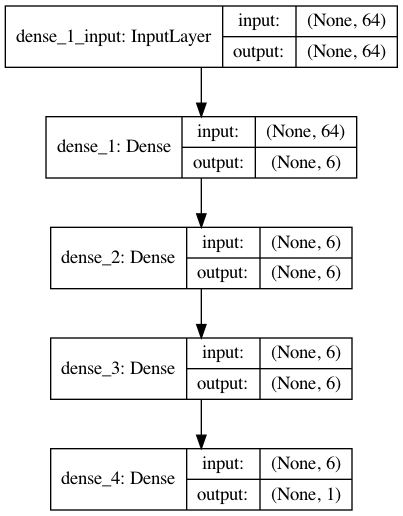

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
ann_viz(model, title="Final Artificial Neural Network")